## Memorization Analysis

This is the colab notebook for the memorization analaysis portion of the paper (Pythia: A Survey of Memory and Attention of LLMs across Training and Size
). GPU is required, and loading larger models will also require higher RAM. 

In order to run this notebook, there are various configurations to change. 


In [1]:
!pip install -q transformers zstandard datasets accelerate bitsandbytes evaluate
from transformers import pipeline, AutoTokenizer, GPTNeoXForCausalLM, GPTNeoXConfig
from torch.utils.data import Dataset, DataLoader, IterableDataset
from datasets import load_dataset
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import numpy as np
import os
# Import stuff
import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
import torch
import matplotlib.pyplot as plt
import numpy as np


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

A little bit about the Pile. There are 299,892,736,000 tokens during training, and 143 checkpoints for each model are saved every 2,097,152,000 tokens, spaced evenly throughout training, from step1000 to step143000 (which is the same as main). In addition, we also provide frequent early checkpoints: step0 and step{1,2,4...512}. This corresponds to training for just under 1 epoch on the Pile for non-deduplicated models, and about 1.5 epochs on the deduplicated Pile.

In [2]:
## CONFIGS 
SIZE = '70m' 
STEPNUM = 98000
BATCH = 8 
device = torch.device("cuda")
split_name = "deduped.70m"
dataset = 'pile' ##pile 

In [3]:
class PileDataset(Dataset):
    is_dataframe = False

    def __init__(self, memories, tokenizer, isPandas = True):
        self.tokenizer = tokenizer
        self.memories = memories
        self.isPandas = isPandas

    def __getitem__(self, index):
      if not self.isPandas:
        tokens = self.memories[index]["tokens"][:64]
      else:
        tokens = self.memories.iloc[index]["tokens"][:64]
      decoded_text = self.tokenizer.decode(tokens)
      return decoded_text

    def __len__(self):
        return len(self.memories["index"])

In [4]:
def load_model(split_name, stepnum):
    isDeduped = split_name.startswith("deduped")
    model = split_name.split("duped.")[-1]
    corresponding_model = f"EleutherAI/pythia-{model}{'-deduped' if isDeduped else ''}"
    return GPTNeoXForCausalLM.from_pretrained(corresponding_model, revision=f'step{stepnum}')

def load_tokenizer(split_name, generation = False):
    isDeduped = split_name.startswith("deduped")
    model = split_name.split("duped.")[-1]
    corresponding_model = f"EleutherAI/pythia-{model}{'-deduped' if isDeduped else ''}"
    tokenizer = AutoTokenizer.from_pretrained(corresponding_model) #ChANGED
    tokenizer.pad_token = tokenizer.eos_token
    return tokenizer

def get_dataset(dataset, split_name, sample=None):
    if dataset == "pile":
        data_scheme = split_name.split(".")[0]
        dataset = load_dataset(f"EleutherAI/pile-{data_scheme}-pythia-random-sampled", split='train')
    else:
        dataset = load_dataset("EleutherAI/pythia-memorized-evals")[split_name].to_pandas()

    return dataset if sample is None else dataset.sample(sample).reset_index(drop=True)

def get_batch_size(split_name):
    size_batch_map = {
        "70m": 256,
        "160m": 128,
        "410m": 128,
        "1b": 128,
        "1.4b": 64,
        "2.8b": 32,
        "6.9b": 32,
        "12b": 16
    }
    model_size = ".".join(split_name.split(".")[1:])
    return size_batch_map[model_size]

In [7]:
# pile_dataset = PileDataset(pile_sequences, tokenizer)
pile_sequences = get_dataset(dataset, split_name) # memories whoo

## Data Section: 

Statistics + Sample entries from our data! Since this is a text dataset, we will provide simple entries of what each document looks like. 

In [9]:
tokenizer = load_tokenizer(split_name)

In [15]:
## Example of what the dataset looks like 

sample_idx = 10

tokenizer.decode(pile_sequences[sample_idx]['tokens'])

' arrest and analysis of cellular pathways targeted by 5m and 5o {#s0035}\n\nInitially, cell cycle arrest was analysed by flow cytometry analysis using propidium iodide (PI) staining of DNA. Huh7 cells treated with **5m** and **5o** showed an increase in entry to G2/M and G1 phases in 48\u2009h ([Figure 4(C)](#F0004){ref-type="fig"}) and 72\u2009h ([Figure 4(D)](#F0004){ref-type="fig"}), respectively. While no arrest was observed in Mahlavu cells treated with **5m** and **5o** for 48\u2009h ([Figure 4(A)](#F0004){ref-type="fig"}), the cells treated with **5m** and **5o** represented a higher cell population in S and G2/M phases for 72\u2009h ([Figure 4(B)](#F0004){ref-type="fig"}). Quantitative results of cell cycle analysis were also revealed in [Table S1](https://doi.org/10.1080/14756366.2018.1504041).\n\n![Detection of cell cycle arrest. Cell cycle analysis of Mahlavu for (**A**) 48\u2009h (**B**) 72\u2009h and Huh7 for (**C**) 48\u2009h and (**D**) 72\u2009h after treatment with co

In [18]:
len(pile_sequences) # length of the dataset, which is a sample of The Pile Dataset 

5000000

In [20]:
len(pile_sequences[sample_idx]['tokens']) # length of the tokens in the dataset before processing 

2048

In [6]:
def sample_dataset(size, pile_dataset):
  sample = pile_dataset.train_test_split(test_size=size, shuffle=True)['test']
  return sample

sample_sequences = sample_dataset(0.1, pile_sequences)

In [ ]:
len(pile_sequences)

50000

In [21]:
pile_sequences

Dataset({
    features: ['index', 'tokens', 'is_memorized'],
    num_rows: 5000000
})

## Tests How Much Memorization!!! 


This is the memorization score that we defined earlier on 


In [ ]:
def memorization_score(original, generated):
  if original.shape != generated.shape:
        raise Exception(f"The two shapes are not the same length: label is {original.shape}, generated seq is {generated.shape}")
  return np.mean(torch.eq(original, generated).cpu().numpy(), axis=1).tolist()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def evaluate(split_name, step_num, pile_sequences, download=False):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  pythia_model = load_model(split_name, step_num)
  pythia_model.to(device)
  
  tokenizer = load_tokenizer(split_name)
  pile_dataset = PileDataset(pile_sequences, tokenizer, isPandas= False)
  batch_size = get_batch_size(split_name)
  data_loader = DataLoader(pile_dataset, batch_size=batch_size)

  ## start evaluating 
  all_scores = []
  K= 32
  with torch.no_grad():
    for batch in tqdm(data_loader, desc=f"Calculating {dataset} k-elicit memory for {split_name}", total=len(data_loader)):
      torch.cuda.empty_cache()
    # for batch in tqdm(data_loader, desc=f"Calculating {dataset} k-elicit memory for {split_name}"):
      tokenized_batch = tokenizer(batch, return_tensors="pt", max_length=512, truncation=True, padding = True)
      tokenized_batch.to(device)
      labels = tokenized_batch["input_ids"][:,-K-1:-1] #remove end of sentence token
      tokenized_batch["attention_mask"] = tokenized_batch["attention_mask"][:,:K]
      tokenized_batch["input_ids"] = tokenized_batch["input_ids"][:,:K]
      outputs = pythia_model.generate(**tokenized_batch, min_new_tokens = K, max_new_tokens=K, pad_token_id=tokenizer.eos_token_id)
      score = memorization_score(outputs[:, -K:], labels)
      all_scores.extend(score)
  from google.colab import files

  scores_df = pd.DataFrame({
      "index": pile_sequences["index"],
      "perplexity": all_scores
    })
  if download:
    file_name = split_name.replace(".", "_") + str(step_num)
    scores_df.to_csv(f"pile_{file_name}.csv", index=False)
    files.download(f"pile_{file_name}.csv")
  return scores_df 

In [ ]:
# save space
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
split_name = "deduped.1.4b"

In [ ]:
scores_df = evaluate(split_name, STEPNUM, pile_sequences, download=True)

Calculating pile k-elicit memory for deduped.1.4b:  28%|██▊       | 217/782 [17:55<46:23,  4.93s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Calculating pile k-elicit memory for deduped.1.4b: 100%|██████████| 782/782 [1:04:23<00:00,  4.94s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The memorization scores will be saved only computer; must upload them on the seperate colab document in order to conduct analysis. 

## bleu ablations 


Did not make the final paper, but this section is dedicated towards looking at memorization if we were using a blue score. in this case, we simply loaded the blue metric 


In [ ]:
predictions = ["hello there general kenobi","foo bar foobar"]
references = [["hello there general kenobi"],["foo bar foobar"]]
bleu = evaluate.load("bleu")
results = bleu.compute(predictions=predictions, references=references)

## Evaluating First Few Sequences 

We will load all pythia tokens that are seen in the first 1000 steps (this is a total of 2B tokens). There are 15 million sequences, and a total of 143 checkpoints (143000 timesteps total). 1/143 * 15 million = 104895 tokens. 

In [ ]:
import gc

In [ ]:
def get_memorized_by_index(index, threshold):
  index = np.array(index) 
  return index[index < threshold]

In [ ]:
def pythia_sequences_edited(pythia_dataset, threshold): 
  filtered_dataset = pythia_dataset.filter(lambda example: example["index"] <= threshold)
  return filtered_dataset 

In [ ]:
filtered_dataset = pile_sequences.train_test_split(test_size=0.95, shuffle=False)

In [ ]:
filtered_dataset['train']

Dataset({
    features: ['index', 'tokens', 'is_memorized'],
    num_rows: 250000
})

In [ ]:
split = pythia_sequences_edited(filtered_dataset['train'], 104895)

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
steps_to_eval = range(0, 143000, 14000)
scores = []
for step in steps_to_eval:
  scores_df = evaluate(split_name, step, filtered_dataset['train'])
  scores.append(scores_df)
  gc.collect()

In [ ]:
def calculate_ratio_memorized(df, threshold):
  scores = np.array(df['perplexity']) 
  count = (scores >= threshold).sum()

# Calculate the fraction of elements that are greater than 1 over the total number of elements
  return count / len(scores)

In [ ]:
ratios = [calculate_ratio_memorized(df) for df in scores]

In [ ]:
epoch = int(filtered_dataset['train'][-1]['index'] / 15000000 * 98000)

In [ ]:
print(epoch)

47875


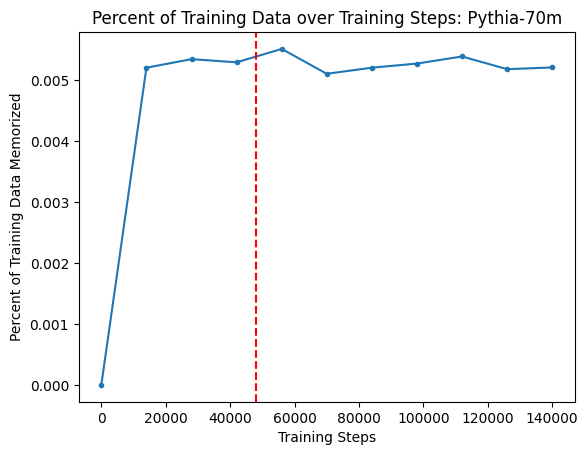

In [ ]:
plot_ratio(ratios)

In [ ]:
def evaluate_memorize_over_time(dataset):
  steps_to_eval = range(0, 98001, 5000)
  scores = []
  for i, step in enumerate(steps_to_eval):
    print(f'Calculating {i}/{len(steps_to_eval)} Steps')
    scores_df = evaluate(split_name, step, dataset)
    scores.append(scores_df)
    gc.collect()
  return steps_to_eval, scores

In [ ]:
def plot_ratio(steps_to_eval, new_scores, epoch, ratio):
    # ratios = [calculate_ratio_memorized(df, ratio) for df in new_scores]
    # plt.plot(steps_to_eval, ratios, markersize=3, marker='o')

    plt.title('Percent of Data Memorized over Training Steps: Pythia-70m')
    plt.xlabel('Training Steps')
    plt.ylabel('Fraction of Data[:47875] Memorized')
    plt.ticklabel_format(style='plain', axis='x')

    plt.axvline(x=epoch, color='r', linestyle='--')

    cmap = plt.cm.get_cmap('viridis')
    for i, r in enumerate(ratio):
        ratios = [calculate_ratio_memorized(df, r) for df in new_scores]
        plt.plot(steps_to_eval, ratios, markersize=3, marker='o', label=f'Ratio: {r}', color=cmap(i/len(ratio)))
        # specify a different color for each line using the colors list
    
    # plt.annotate('Point which All Data Seen', xy=(5, 0.9), xytext=(5.5, 0.95),
    #             arrowprops=dict(facecolor='black', shrink=0.05),
    #             fontsize=12)

    # Displaying the plot
    plt.legend()
    plt.show()

In [ ]:
filtered = pile_sequences.train_test_split(test_size=0.995, shuffle=False)
dataset_to_eval = filtered['train']

In [ ]:
len(dataset_to_eval)

25000

In [ ]:
epoch = int(dataset_to_eval[-1]['index'] / 15000000 * 98000)
print(epoch)

4815


In [ ]:
len(dataset_to_eval)

25000

In [ ]:
new_step_to_eval, new_scores = evaluate_memorize_over_time(dataset_to_eval)

<ipython-input-393-47f215cd4053>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


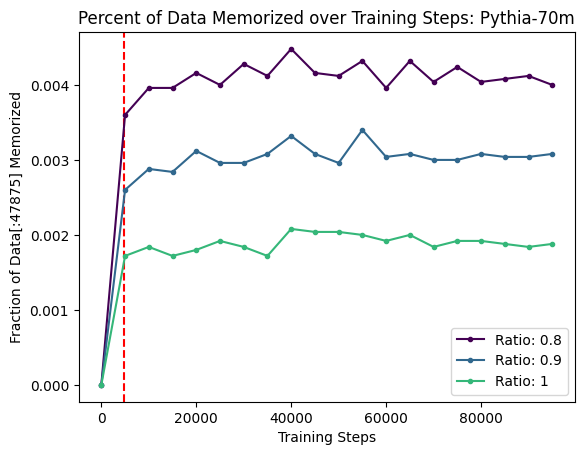

In [ ]:
plot_ratio(new_step_to_eval, new_scores, epoch, [0.8, 0.9, 1])

In [ ]:
new_scores

In [ ]:
for step, df in zip(new_step_to_eval, new_scores):
  df['steps'] = step

In [ ]:
final = pd.concat(new_scores)

In [ ]:
final.to_csv(f"overtime.csv", index=False)
files.download(f"overtime.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Analysis of Memorization 
We are going to create the following plot after loading in our dataframe. First, we will look at the percent of the sequences memorized for each interval. There are a total of 

In [ ]:
from google.colab import files 
results = files.upload()

Saving pileto98000step.csv to pileto98000step.csv


In [ ]:
import io
 
df = pd.read_csv('pile_deduped_70m.csv')
print(df)

             index  perplexity
0               18     0.09375
1               43     0.00000
2               86     0.06250
3              110     0.00000
4              112     0.00000
...            ...         ...
4999995  146431872     0.00000
4999996  146431904     0.12500
4999997  146431927     0.00000
4999998  146431960     0.03125
4999999  146431973     0.06250

[5000000 rows x 2 columns]


In [ ]:
def get_ratios(rat, index, counts, all_scores, interval, total_bins): #ratio in which you should exceed, 
  """
  You have array all_scores: all the scores that you need to bucket into 15 buckets with range from 1 -> 15 million, with an interval of 1 million, and bucket by using index array: x 
  you need to returna list that counts the number of scores that are above a threshold "rat" for each range. 
  """
  index = np.array(index)
  all_scores = np.array(all_scores)

  memorized_counts = []
  for r in range(total_bins):
    threshold = np.logical_and(index >= interval * r, index < (r+1) * interval).astype(int)
    threshold = np.logical_and(threshold, all_scores >= rat).astype(int)
    memorized_counts.append(np.sum(threshold))
  return [a/b for a, b in zip(memorized_counts, counts)]

In [ ]:
def plot_ratio(r, interval):
    ranges = np.arange(0, 15000001, interval)[1:] / 1000 
    plt.plot(ranges, r, '-o', markersize=3, marker='o')

    plt.title('Percent of Training Data K-32 Memorized: Pythia-70m-98000')
    plt.xlabel('Index of Sequence (In Thousands)')
    plt.ylabel('Percent of Training Data Memorized')
    plt.ticklabel_format(style='plain', axis='x')

    # Displaying the plot
    plt.show()

In [ ]:
def plot_ratio_over_bins(df, ratio, total_bins):
  index = np.array(df['index'])
  all_counts = df['perplexity'] 
  counts, _ = np.histogram(x, bins=total_bins, range=(1, 15000001))
  interval = 15000000 // total_bins
  r = get_ratios(ratio, index, counts, all_counts, interval, total_bins)
  plot_ratio(r, interval)

<ipython-input-146-afd0937b1deb>:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(ranges, r, '-o', markersize=3, marker='o')


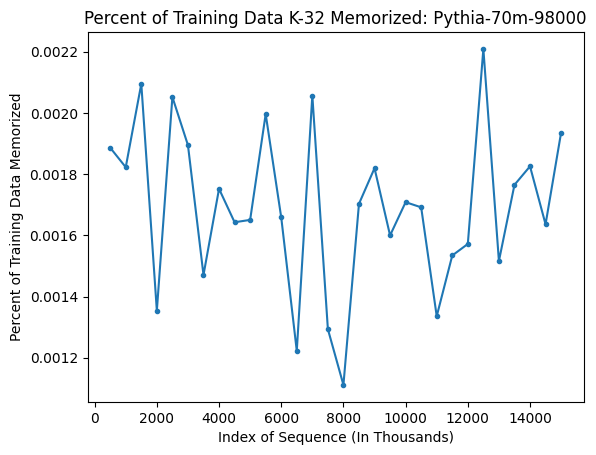

In [ ]:
plot_ratio_over_bins(df, 1, 30)

In [ ]:
def distribution_of_scores(df):
  # Create a histogram of the scores
  scores = df['perplexity'] 
  scores = scores[scores > 0.5]
  # bins = np.linspace(0, 1, num=100)
  plt.hist(scores, bins=50, density=True, width=0.02)
  # Set the title and axis labels
  plt.title("Distribution of Memorization Score")
  plt.xlabel("Score")
  plt.ylabel("Frequency")

  # Show the plot
  plt.show()

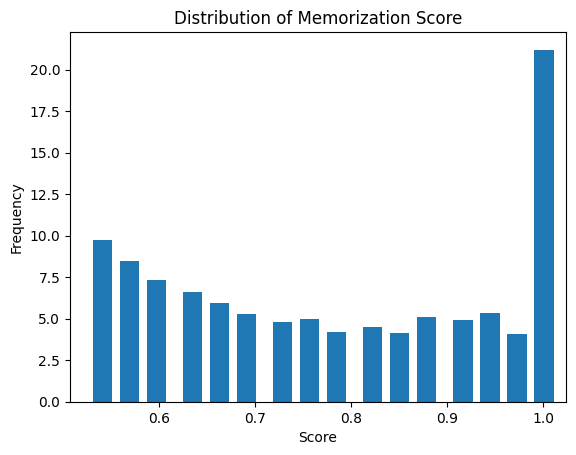

In [ ]:
distribution_of_scores(df)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 16>:16                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'Text' object is not callable

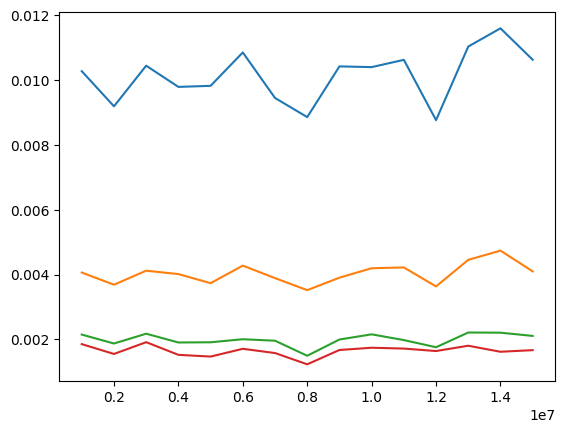

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# Plotting the ratios with lines connecting each data point
plt.plot(x, ratio, '-o')

# Setting the plot title and axis labels
plt.title('15 Ratios with Lines Connecting Data Points')
plt.xlabel('Index Point (1 million interval)')
plt.ylabel('Ratio Value')

# Displaying the plot
plt.show()





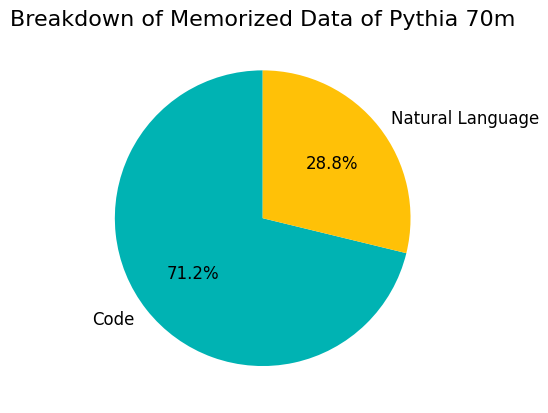

In [ ]:
import matplotlib.pyplot as plt

# Define data
labels = ['Code', 'Natural Language']
sizes = [71.2, 28.8]
colors = ['#3498db', '#e74c3c']

colors = ['#00b3b3', '#ffc107'] # Teal and amber colors
textprops = {'fontsize': 12} # Increase font size of labels and title

# Create pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops=textprops)

# Set title and increase font size
ax.set_title('Breakdown of Memorized Data of Pythia 70m', fontsize=16)

# Show plot
plt.show()

In [ ]:
def evaluate(pile_sequences, tokenizer, model, K=32):
  pythia_model.to(device)
  pile_dataset = PileDataset(pile_sequences, tokenizer)
  batch_size = get_batch_size(split_name)
  data_loader = DataLoader(pile_dataset, batch_size=batch_size)
  all_scores = []
  bleu_scores = []
  with torch.no_grad():
    for batch in tqdm(data_loader, desc=f"Calculating {dataset} k-elicit memory for {split_name}", total=len(data_loader)):
    # for batch in tqdm(data_loader, desc=f"Calculating {dataset} k-elicit memory for {split_name}"):
      tokenized_batch = tokenizer(batch, return_tensors="pt", max_length=512, truncation=True, padding = True)
      tokenized_batch.to(device)
      labels = tokenized_batch["input_ids"][:,-K-1:-1] #remove end of sentence token
      tokenized_batch["attention_mask"] = tokenized_batch["attention_mask"][:,:K]
      tokenized_batch["input_ids"] = tokenized_batch["input_ids"][:,:K]
      outputs = pythia_model.generate(**tokenized_batch, min_new_tokens = K, max_new_tokens=K, pad_token_id=tokenizer.eos_token_id)
      score = memorization_score(outputs[:, -K:], labels)
      all_scores.extend(score)
  perplexities_df = pd.DataFrame({
    "index": pile_sequences["index"],
    "perplexity": all_scores
  })
  file_name = split_name.replace(".", "_")
  perplexities_df.to_csv(f"all_scores_{file_name}.csv", index=False)
  files.download(f"all_scores_{file_name}.csv")
  return all_scores 

evaluate(pile_sequences, tokenizer, model)

### Training Dynamics + Attention Across Time 


Idea here is we want to see how models develop over time. We will first analyze the differences in the weights of the models. For every single model in a checkpoint, we will observe the difference in weights for each of the attention layers + sum over the absolute value of each of the attention heads. 

We want to observe:
- how much each layer changes between checkpoint for FFN layers 
- how much attention each head changes between (12, 12) heads. 

In [ ]:
def load_model_step(step_size, split_name):
  isDeduped = split_name.startswith("deduped")
  model = split_name.split("duped.")[-1]
  corresponding_model = f"EleutherAI/pythia-{model}{'-deduped' if isDeduped else ''}"
  return GPTNeoXForCausalLM.from_pretrained(
      corresponding_model,
      revision=f"step{STEPNUM}",
      cache_dir=f"./pythia-{SIZE}-deduped/step{STEPNUM}",
  )

In [ ]:
model_sizes = [0, 1, 3....] #figure out all the sizes of the models 


Next, we want to observe the development of the attention heads. There are a couple of different attention heads - first, there are induction heads (https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html)  and there are also positional heads (https://aclanthology.org/W19-4828.). We will observe throughout the training size of the model, whether these heads are thoroughly developed. 

In [ ]:
from google.colab import files
perplexities_df = pd.DataFrame({
  "index": pile_sequences["index"],
  "perplexity": all_scores
})
file_name = split_name.replace(".", "_")
perplexities_df.to_csv(f"all_scores_{file_name}.csv", index=False)
# print(perplexities_df)
# df.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download(f"all_scores_{file_name}.csv")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = load_tokenizer(split_name)
pythia_model = load_model(split_name)
pythia_model.to(device)
pile_dataset = PileDataset(pile_sequences, tokenizer)
# pile_dataset = IterativePileDataset(pile_sequences, tokenizer)
assert isinstance(pile_dataset, torch.utils.data.IterableDataset)

batch_size = get_batch_size(split_name)
data_loader = DataLoader(pile_dataset, batch_size=batch_size)

from google.colab import files
perplexities_df = pd.DataFrame({
  "index": pile_sequences["index"],
  "perplexity": all_perplexities
})
file_name = split_name.replace(".", "_")
perplexities_df.to_csv(f"{file_name}.csv", index=False)
# print(perplexities_df)
# df.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download(f"{file_name}.csv")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 5>:5                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'pile_sequences' is not defined

In [ ]:
x[:10]

0     441
1     447
2     792
3    1539
4    1705
5    3050
6    3509
7    3851
8    3870
9    4942
Name: index, dtype: int64

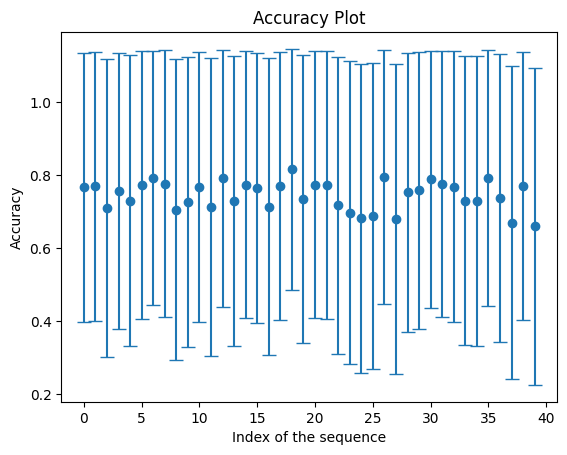

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# Set the x-axis to be the index of the sequence
x = pile_sequences["index"]
data = all_scores

# Split the data into chunks of 1000
chunks = np.array_split(data, 40)

# Calculate the average of each chunk
averages = np.array([np.mean(chunk) for chunk in chunks])
std_devs = np.array([np.std(chunk) for chunk in chunks])
x = np.arange(len(averages))

# Plot the data
ax.errorbar(x, averages, yerr=std_devs, fmt='o', capsize=5)

# ax.plot(x, averages)

# Add labels to the axes and a title to the plot
ax.set_xlabel('Index of the sequence')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Plot')

# Show the plot
plt.show()

In [ ]:
print(all_scores)

[0.845458984375, 0.8372802734375, 0.876220703125, 0.8197021484375, 0.8338623046875, 0.8284912109375, 0.8009033203125, 0.8125, 0.8216552734375, 0.839599609375, 0.8111572265625, 0.84326171875]


In [ ]:
all_perplexities = np.array([])
def calculate_perplexity(logits, labels):
    # Store the probabilities for each token. These will be summed later, but having the
    # individual probabilities is helpful for debugging.
    token_probs = []

    # Don't include the final token logits. There are no labels for
    # these since the sequence has ended.
    num_special_tokens = len(labels[labels == 0])
    num_normal_tokens = len(labels) - num_special_tokens

    for token_index in range(num_normal_tokens - 1):
        # Map the logits to probabilities.
        predicted_probs = torch.softmax(logits[token_index], dim=0)
        # Get the probability of the correct label.
        label_prob = predicted_probs[labels[token_index + 1]]
        # Store the probability for this token.
        token_probs.append(label_prob.detach())

    # Caluclate the log-likelyhood of the sequence by summing the probabilities
    # of each token and then taking the log.
    log_likelihood = torch.log(torch.stack(token_probs)).sum()

    # Caluclate the cross entropy by dividing the negative log-likelihood by the number of tokens.
    cross_entropy = -log_likelihood / len(token_probs)

    # Calculate the perplexity by taking the exponential of the cross entropy.
    perplexity = torch.exp(cross_entropy).item()
    # assert perplexity != float("inf"), "Perplexity is infinite. This is probably due to a token that has a probability of 0."
    return perplexity

In [ ]:
with torch.no_grad():
  for batch in tqdm(data_loader, desc=f"Calculating {dataset} perplexities for {split_name}"):
      tokenized_batch = tokenizer(batch, return_tensors="pt", max_length=512, truncation=True, padding=True)
      tokenized_batch.to(device)
      labels = tokenized_batch["input_ids"]

      outputs = pythia_model(**tokenized_batch, labels=tokenized_batch["input_ids"])
      logits = outputs.logits.detach()

      perplexities = [calculate_perplexity(logits[i], labels[i]) for i in range(len(logits))]
      all_perplexities = np.append(all_perplexities, perplexities)

In [ ]:

# outputs = model.generate(**inputs, max_new_tokens=5, return_dict_in_generate=True, output_scores=True)
# transition_scores = model.compute_transition_scores(
#     outputs.sequences, outputs.scores, normalize_logits=True
# ) #This might be useful later on if we are using transition scores in any way? 
# https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/text_generation#transformers.GenerationMixin.generate


#load the models we are using

# model = GPTNeoXForCausalLM.from_pretrained(
#   f"EleutherAI/pythia-{SIZE}-deduped",
#   revision=f"step{STEPNUM}",
#   cache_dir=f"./pythia-{SIZE}-deduped/step{STEPNUM}",
# )

# tokenizer = AutoTokenizer.from_pretrained(
#   f"EleutherAI/pythia-{SIZE}-deduped",
#   revision=f"step{STEPNUM}",
#   cache_dir=f"./pythia-{SIZE}-deduped/step{STEPNUM}",
# )

model.to(device)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attention): GPTNeoXAttention(
          (rotary_emb): RotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (embed_out): Linear(in_features=512, out_features=50304, bias=False)
)

In [ ]:
split_name = "duped.70m"
memories = load_dataset("EleutherAI/pythia-memorized-evals", split = split_name) 
# tokenizer = load_tokenizer(split_name)
# memories_dataset = HFMemoriesDataset(
#     memories, 
#     tokenizer)

Extracting data files:   0%|          | 0/16 [00:00<?, ?it/s]

Generating duped.6.9b split:   0%|          | 0/2120969 [00:00<?, ? examples/s]

Generating deduped.6.9b split:   0%|          | 0/1680294 [00:00<?, ? examples/s]

Generating duped.1b split:   0%|          | 0/1256141 [00:00<?, ? examples/s]

Generating duped.1.4b split:   0%|          | 0/1373722 [00:00<?, ? examples/s]

Generating deduped.1b split:   0%|          | 0/1032865 [00:00<?, ? examples/s]

Generating deduped.1.4b split:   0%|          | 0/1048097 [00:00<?, ? examples/s]

Generating duped.12b split:   0%|          | 0/2382326 [00:00<?, ? examples/s]

Generating duped.410m split:   0%|          | 0/970341 [00:00<?, ? examples/s]

Generating duped.160m split:   0%|          | 0/689673 [00:00<?, ? examples/s]

Generating deduped.12b split:   0%|          | 0/1871215 [00:00<?, ? examples/s]

Generating deduped.70m split:   0%|          | 0/411448 [00:00<?, ? examples/s]

Generating duped.2.8b split:   0%|          | 0/1675077 [00:00<?, ? examples/s]

Generating duped.70m split:   0%|          | 0/463953 [00:00<?, ? examples/s]

Generating deduped.160m split:   0%|          | 0/581195 [00:00<?, ? examples/s]

Generating deduped.410m split:   0%|          | 0/811039 [00:00<?, ? examples/s]

Generating deduped.2.8b split:   0%|          | 0/1355211 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/EleutherAI___parquet/EleutherAI--pythia-memorized-evals-623aaa371a33821a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [ ]:
def get_dataset(dataset, split_name, sample=None):
    if dataset == "pile":
        data_scheme = split_name.split(".")[0]
        dataset = load_dataset(f"EleutherAI/pile-{data_scheme}-pythia-random-sampled")["train"].to_pandas()
    else:
        dataset = load_dataset("EleutherAI/pythia-memorized-evals")[split_name].to_pandas()

    return dataset if sample is None else dataset.sample(sample).reset_index(drop=True)


## Examples of Sequences the Model has Memorized 

This is the section where we look at the sequences the model has memorized and document them. 


In [ ]:
pile_sequences = get_dataset("memories", split_name)

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
pile_dataset = PileDataset(pile_sequences, tokenizer)

In [ ]:
class IterativePileDataset(IterableDataset):
  is_dataframe = False
  
  def __init__(self, memories, tokenizer): 
    self.tokenizer = tokenizer
    self.memories = memories
  
  def process_data(self, data):
    for x in data:
      yield self.tokenizer.decode(x['tokens'][:64]) 

  def get_stream(self, data):
    return cycle(self.process_data(data))  

  def __iter__(self):
    return iter(self.process_data(self.memories))
    # tokens = iter(self.memories)["tokens"][:64]
    # decoded_text = self.tokenizer.decode(tokens)
    # return decoded_text

In [ ]:
dataloader = DataLoader(pile_dataset, batch_size=BATCH)

In [ ]:
# Get the first item from the dataloader
first_item = next(iter(dataloader))

In [ ]:
print(first_item)

{'index': tensor([ 232,  764,  806,  891, 1060, 1278, 1438, 1486]), 'tokens': [tensor([  996,   599,   313,    94,  4022, 32075,  6651,  1717]), tensor([  186, 17585, 39386,   187,   305,    15,  9103,  3011]), tensor([   29,   423,    27, 50262, 48095,  8418, 35739,    13]), tensor([ 1088,    92, 19939,    61,  4477,    15,    13,  1717]), tensor([ 7392,  3728,   428,  2099,    15,  2061, 47823,  3680]), tensor([  568, 12945,  5270,    92,   187,    16,    13,    13]), tensor([29860,   423,   310,  8798,   475,    49, 49466,  1717]), tensor([5264,   92, 1239,   94,  187, 2277, 1556, 3046]), tensor([21694,  3306,   760,   187,   475,    16,    13,    13]), tensor([13544,   724,    10, 50262, 21737,    21, 38152,  1717]), tensor([  79, 1890,  187,   61,  762,   15,   13, 1549]), tensor([  870,  1202, 12641,  2099,   253,    17,   187,    13]), tensor([21694,  8604, 47150,    92, 14325,    15,   475,  1717]), tensor([2730,   60,  933, 8860, 4637,   17, 8021, 3832]), tensor([ 8992,   805,

In [ ]:
tokenizer(first_item, return_tensors='pt', max_length = 512, truncation = True, padding = True)

In [ ]:
# first_item.to(device)
input = torch.tensor(first_item['tokens'])
model.generate(input) 

TypeError: ignored

In [ ]:
for _, batch in enumerate(tqdm(dataloader)):
  # led the model generate tokens
  batch = batch.to(device)
  inputs = tokenizer(batch, return_tensors="pt") #maybe create 
  tokens = model.generate(**inputs, max_length = 64)
  print()


In [ ]:
len(memories)

463953

In [ ]:
example = memories[4]

In [ ]:
print(example)

{'index': 1060, 'tokens': [4022, 305, 48095, 4477, 15, 187, 475, 187, 475, 21737, 762, 253, 14325, 4637, 13, 11099, 374, 15, 17, 313, 783, 346, 17736, 3287, 187, 475, 368, 778, 417, 897, 436, 1873, 3707, 275, 10276, 342, 253, 4637, 15, 187, 475, 1422, 778, 4044, 247, 3491, 273, 253, 4637, 387, 187, 475, 187, 475, 50273, 2413, 1358, 2700, 15, 8418, 15, 2061, 16, 17130], '__index_level_0__': 1060}


In [ ]:
len(example['tokens'][:32])

32

In [ ]:
inputString = tokenizer.decode(example['tokens'][:32])
actualResult = tokenizer.decode(example['tokens'])

In [ ]:
print(inputString)
print("SEPERATE")
print(len(actualResult)) 

 2016 gRPC authors.
 *
 * Licensed under the Apache License, Version 2.0 (the "License");
 * you may not use this file
SEPERATE
123


In [ ]:
inputs = tokenizer(inputString, return_tensors="pt")
tokens = model.generate(**inputs, max_length = 64)

result = tokenizer.decode(tokens[0])
print(result)
print("---------")
print(actualResult)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 2016 gRPC authors.
 *
 * Licensed under the Apache License, Version 2.0 (the "License");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 * http://www.apache.org/licenses/
---------
 2016 gRPC authors.
 *
 * Licensed under the Apache License, Version 2.0 (the "License");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses


In [ ]:
inputs = tokenizer("Hello, I am", return_tensors="pt")
tokens = model.generate(**inputs)
tokenizer.decode(tokens[0])

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


'Hello, I am looking for a way to get my name in the mail. I am looking for'